In [2]:
import pandas as pd
import numpy as np
import requests
import re
from Bio import SeqIO
import subprocess
import cobra

def ko2genes(ko):
    url = 'http://rest.kegg.jp/link/genes/' + ko
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['ko','gene'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

def download_seqs(geneList,fileName,batchSize):    
    geneList_chunks = [geneList[i * batchSize:(i + 1) * batchSize] for i in range((len(geneList) + batchSize - 1) // batchSize )]
    with open(fileName,'w') as fastafile:
        for sglist in geneList_chunks:
            url =  'http://rest.kegg.jp/get/' + "+".join(sglist) + '/aaseq'
            fseqs = requests.get(url).text
            fastafile.write(fseqs)

            
def msaSeq2df(seq,indexStart):
    idx = []
    resid = []
    j = indexStart;
    for i in seq:
        resid.append(i)
        if i == '-':
            idx.append(np.nan)
        else:
            idx.append(j)
            j = j+1
    
    return pd.DataFrame({'residue': resid, 'index': idx})

def ecogenes():
    url = 'http://rest.kegg.jp/link/ko/eco'
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['gene','ko'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

get_resid = lambda x: [x for x in re.findall(r'\D',x) if len(x)>0][0]
get_resid_idx = lambda x: [int(x) for x in re.findall(r'\d*',x) if len(x)>0][0]


# load the structural annotations and only keep NAD binding enzymes with single D or E residues 
structure = pd.read_csv('../assets/structure/oxidoreductases_residue_annotation.csv',index_col=0)
structure = structure[structure['Coenzyme'].isin(['NAD','NADH'])]
structure = structure[structure['Residues'].apply(lambda x: (len(x.split(';')) < 2) & (x[0] in ['E','D']))]

taxonomy = pd.read_csv('../assets/kegg/KEGG_taxonomy_final.csv')

In [17]:
order_filter = 'phylum'
name = 'Proteobacteria'
taxons = taxonomy[taxonomy[order_filter].isin([name])].kegg_id.unique().tolist()

In [36]:
for idx,row in structure.iterrows():
    genes = ko2genes(row.KO)
    genes['species'] = genes['gene'].apply(lambda x: x.split(':')[0])
    ge = genes[genes.species.isin(taxons)]
    gl = ge.gene.unique().tolist()
    # add the homolog from the structural analysis to the gene set
    gl = list(set(gl + [row['Homolog-KEGG']]))
    download_seqs(gl,'../assets/kegg/orthogroups_' + order_filter + '/' + row.KO + '_' +  name + '.fasta',10)
    print('finished downloading :' + row.KO + '; num seqs: ' + str(len(gl)))

finished downloading :K00215; num seqs: 1565
finished downloading :K00382; num seqs: 2705
finished downloading :K00121; num seqs: 1200
finished downloading :K03778; num seqs: 701
finished downloading :K13953; num seqs: 879
finished downloading :K00027; num seqs: 636
finished downloading :K06447; num seqs: 671
finished downloading :K00134; num seqs: 2324
finished downloading :K00013; num seqs: 1343
finished downloading :K00012; num seqs: 1464
finished downloading :K00067; num seqs: 1182
finished downloading :K03473; num seqs: 602
finished downloading :K00024; num seqs: 1296
finished downloading :K00060; num seqs: 649
finished downloading :K02472; num seqs: 464
finished downloading :K00052; num seqs: 1367
finished downloading :K00073; num seqs: 195
finished downloading :K04072; num seqs: 445
finished downloading :K07246; num seqs: 628
finished downloading :K00335; num seqs: 1410
finished downloading :K14187; num seqs: 493
finished downloading :K00048; num seqs: 205
finished downloading :

In [39]:
for idx,row in structure.iterrows():
    ko = row.KO
    fin = '../assets/kegg/orthogroups_' + order_filter + '/' + row.KO + '_' +  name + '.fasta'
    fout = '../assets/kegg/orthogroups_' + order_filter + '/msa/' + row.KO + '_' +  name + '.MSA.fasta'
    call = '/Users/Joshua.Goldford/opt/miniconda3/bin/muscle -in ' + fin + ' -out ' + fout
    subprocess.call(call,shell=True)
    print('finished with mutiple sequence alignment: ' + ko )

finished with mutiple sequence alignment: K00215
finished with mutiple sequence alignment: K00382
finished with mutiple sequence alignment: K00121
finished with mutiple sequence alignment: K03778
finished with mutiple sequence alignment: K13953
finished with mutiple sequence alignment: K00027
finished with mutiple sequence alignment: K06447
finished with mutiple sequence alignment: K00134
finished with mutiple sequence alignment: K00013
finished with mutiple sequence alignment: K00012
finished with mutiple sequence alignment: K00067
finished with mutiple sequence alignment: K03473
finished with mutiple sequence alignment: K00024
finished with mutiple sequence alignment: K00060
finished with mutiple sequence alignment: K02472
finished with mutiple sequence alignment: K00052
finished with mutiple sequence alignment: K00073
finished with mutiple sequence alignment: K04072
finished with mutiple sequence alignment: K07246
finished with mutiple sequence alignment: K00335
finished with mutipl

In [69]:
ko_list =  [];
residue_list = []
residue_ref_idx = []
residue_msa_idx = []
count_occured = []
count_not_occured = []
frac_occured = []

dfs = []

for idx,row in structure.iterrows():
    ko = row.KO
    msa_file = '../assets/kegg/orthogroups_' + order_filter + '/msa/' + row.KO + '_' +  name + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0] in list(seq_dict):
        seq_id = structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0]
        r = structure[structure.KO == ko].Residues[0].split(';')
        r  = [x for x in r if x not in ['Unclear',None]]
        if len(r) > 0:
            r = pd.DataFrame({'residue': [get_resid(y) for y in r],'index':[get_resid_idx(y) for y in r]})
            seq = str(seq_dict[seq_id].seq)
            seqdf = msaSeq2df(seq,1)
            sdf = seqdf[seqdf['index'].isin(r['index'].tolist())]
            for midx,row2 in sdf.iterrows():
                chars = [y.seq[midx] for y in list(seq_dict.values())]
                z = pd.DataFrame({'idx':chars}).reset_index().groupby('idx').count()
                z2 = z.reset_index()
                z2.columns = ['residue','numSeqs']
                z2['ref_residue'] = row2.residue
                z2['ref_residue_idx'] = row2['index']
                z2['KO'] = ko
                dfs.append(z2)
                #frac = z.loc[row2.residue]['index'] / z['index'].sum()
                ##ko_list.append(ko)
                #residue_list.append(row2.residue)
                #residue_ref_idx.append(row2['index'])
                #residue_msa_idx.append(midx)
                #count_occured.append(z.loc[row2.residue]['index'])
                #count_not_occured.append(z['index'].sum() - z.loc[row2.residue]['index'])
                #frac_occured.append(frac)

#results = pd.DataFrame({'ko':ko_list,'residue':residue_list,'idx': residue_ref_idx, 'midx': residue_msa_idx, 'count': count_occured, 'ncount': count_not_occured, 'frac': frac_occured})    

In [71]:
dfs = pd.concat(dfs,axis=0)

In [75]:
len(dfs.groupby(['KO','ref_residue_idx']))

23

In [78]:
len(dfs.KO.unique())

23

In [127]:
r = {'KO': [], 'de_seq': [], 'n_seq': [],'wt_residue':[]}
dfs_new = []
for idx,dff in dfs.groupby('KO'):
    de_seqs = dff[[x in ['D','E'] for x in dff['residue']]].numSeqs.sum()
    nseqs = dff[[x not in ['D','E'] for x in dff['residue']]].numSeqs.sum()
    r['KO'].append(idx); r['de_seq'].append(de_seqs); r['n_seq'].append(nseqs)
    r['wt_residue'].append(dff.ref_residue.unique())
    dff['proportion'] = dff['numSeqs'] / dff['numSeqs'].sum()
    dfs_new.append(dff)
r = pd.DataFrame(r)
r = r[r['wt_residue'].apply(lambda x: x[0] in ['D','E'])]

In [128]:
r['frac_de'] = r['de_seq'] / (r['de_seq'] + r['n_seq'])

In [131]:
dfs_new = pd.concat(dfs_new,axis=0)
dfs_new = dfs_new[dfs_new['ref_residue'].isin(['D','E'])]

In [145]:
prop = dfs_new.pivot_table(index='KO',columns = ['residue'],values='proportion').fillna(0).T

In [164]:
p = prop.T.join(structure.reset_index()[['KO','gene name']].set_index('KO')).reset_index()
p['id'] = p['gene name'] + ' (' + p['KO'] + ')'
p.set_index(['KO','gene name'],inplace=True)
p.set_index('id',inplace=True)

In [169]:
dfst_normalized = pd.read_hdf('../scc/relativeGrowthRates.StoichAndThermo.MR4.hdf','df')

,-,A,C,D,E,G,H,I,K,L,N,P,Q,R,S,T,V,Y
id,,,,,,,,,,,,,,,,,,
ugd (K00012),0.008880,0.002049,0.000000,0.918716,0.047131,0.000683,0.000000,0.000000,0.000000,0.001366,0.000000,0.004098,0.000000,0.000683,0.014344,0.000000,0.000683,0.001366
hisD (K00013),0.000745,0.000000,0.000000,0.982130,0.013403,0.000745,0.000000,0.000000,0.001489,0.000000,0.001489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mdh (K00024),0.003086,0.000000,0.000000,0.738426,0.020062,0.002315,0.003858,0.001543,0.001543,0.000000,0.003086,0.000000,0.220679,0.001543,0.003086,0.000000,0.000772,0.000000
maeA (K00027),0.000000,0.000000,0.000000,0.996855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001572,0.000000,0.000000,0.000000,0.001572,0.000000,0.000000,0.000000
garR (K00042),0.001328,0.023904,0.000000,0.398406,0.025232,0.083665,0.000000,0.000000,0.017264,0.001328,0.140770,0.001328,0.013280,0.011952,0.017264,0.261620,0.002656,0.000000
leuB (K00052),0.000000,0.000000,0.000000,0.988296,0.000000,0.000000,0.000732,0.000000,0.005852,0.000000,0.000732,0.001463,0.000000,0.000000,0.002195,0.000732,0.000000,0.000000
tdh (K00060),0.000000,0.000000,0.000000,0.995378,0.003082,0.001541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rfbD (K00067),0.010998,0.071912,0.000846,0.363790,0.013536,0.227580,0.002538,0.013536,0.007614,0.009306,0.016920,0.004230,0.000846,0.070220,0.071066,0.090525,0.023689,0.000846
allD (K00073),0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [179]:
ids = structure.reset_index()[['KO','gene name','gene id']]
ids['id'] = ids['gene name'] + ' (' + ids['KO'] + ')'

In [188]:
dfst_normalized = dfst_normalized.rename(columns=dict(zip(ids['gene id'],ids['id'])))

In [434]:
mean_rgr = dfst_normalized[[x for x in list(p.T) if x in list(dfst_normalized)]].min().sort_values()

In [435]:
conservation = p['E'] + p['D']

In [436]:
cpr = pd.DataFrame(conservation,columns = ['conservation']).join(pd.DataFrame(mean_rgr,columns=['min growth rate'])).dropna()

id
ugd (K00012)     0.965847
hisD (K00013)    0.995532
mdh (K00024)     0.758488
maeA (K00027)    0.996855
garR (K00042)    0.423639
leuB (K00052)    0.988296
tdh (K00060)     0.998459
rfbD (K00067)    0.377327
allD (K00073)    1.000000
frmA (K00121)    0.997500
gapA (K00134)    0.818847
dapB (K00215)    0.647284
wecC (K02472)    0.993534
pdxB (K03473)    1.000000
ldhA (K03778)    0.904422
adhE (K04072)    0.986517
astD (K06447)    0.998510
yiaK (K08092)    0.869347
adhP (K13953)    0.691695
dtype: float64

In [437]:

def label_point(x, y, val, ax):
    a = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], point['val'])

In [438]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [439]:
cpr.reset_index()['id'].tolist()

[]

In [440]:
thermo = pd.read_csv('../assets/EC_1.X.1.X.Unique_NAD(P)_Coupled.GeneSet.Thermo.csv')
model = cobra.io.read_sbml_model('../assets/iJO1366.xml')

In [441]:
cprt = cpr.join(ids.set_index('id')).reset_index().set_index('gene id').join(thermo.set_index('gene'))

In [442]:
coenzyme = []
oxidizing = [];

for rxn in cprt.reaction:
    
    rsub = [x for x in model.reactions if x.id ==rxn][0]
    stoich = {x.id:y for x,y in rsub.metabolites.items()}
    if 'nad_c' in list(stoich):
        coenzyme.append('NAD')
        if stoich['nad_c'] < 0:
            oxidizing.append(True)
        else:
            oxidizing.append(False)
    else:
        coenzyme.append('NADP')
        if stoich['nadp_c'] < 0:
            oxidizing.append(True)
        else:
            oxidizing.append(False)

In [371]:
rxn = 'FALDH2';
rsub = [x for x in model.reactions if x.id ==rxn][0]
stoich = {x.id:y for x,y in rsub.metabolites.items()}

In [372]:
stoich

{'hmgth_c': -1.0, 'nad_c': -1.0, 'Sfglutth_c': 1.0, 'h_c': 1.0, 'nadh_c': 1.0}

In [443]:
cprt['coenzyme'] = coenzyme
cprt['oxidizing'] = oxidizing

In [444]:
cprt_nad = cprt[cprt['coenzyme'].isin(['NAD'])]

In [445]:
cprt_nad['deltaG'] = (1*cprt_nad['oxidizing'] * 2  - 1) * cprt_nad['deltaG_prime_m']

In [446]:
cprt_nad

,id,conservation,min growth rate,KO,gene name,reaction,gene_name,deltaG_prime_m,deltaG_prime_m (error),coenzyme,oxidizing,deltaG


<AxesSubplot:xlabel='conservation', ylabel='deltaG'>

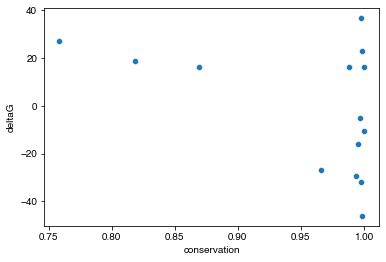

In [386]:
sns.scatterplot(x='conservation',y='deltaG',data=cprt_nad)

<AxesSubplot:xlabel='conservation', ylabel='mean growth rate'>

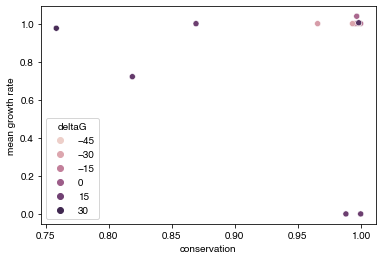

In [387]:
sns.scatterplot(x='conservation',y='mean growth rate',hue='deltaG',data=cprt_nad)

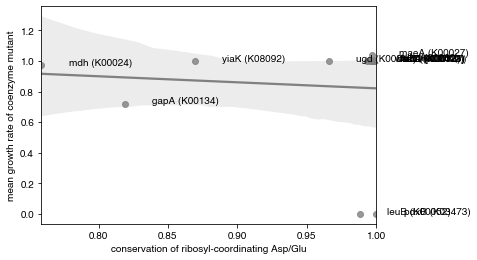

In [389]:

ax = sns.regplot(x='conservation',y='mean growth rate',data=cprt_nad,color='grey')
label_point(cprt_nad['conservation'].tolist(),cprt_nad['mean growth rate'].tolist(),cprt_nad.reset_index()['id'].tolist(),ax)
plt.xlabel('conservation of ribosyl-coordinating Asp/Glu')
plt.ylabel('mean growth rate of coenzyme mutant')
plt.savefig('Proteobacteria.DE.conservation.Vs.GrowthRate.svg')

In [253]:
cpr.reset_index()['id'].tolist()

['ugd (K00012)',
 'hisD (K00013)',
 'mdh (K00024)',
 'maeA (K00027)',
 'leuB (K00052)',
 'tdh (K00060)',
 'rfbD (K00067)',
 'allD (K00073)',
 'frmA (K00121)',
 'gapA (K00134)',
 'dapB (K00215)',
 'wecC (K02472)',
 'pdxB (K03473)',
 'astD (K06447)',
 'yiaK (K08092)']

In [223]:
help(cpr.corr())

Help on DataFrame in module pandas.core.frame object:

class DataFrame(pandas.core.generic.NDFrame)
 |  DataFrame(data=None, index: Union[Collection, NoneType] = None, columns: Union[Collection, NoneType] = None, dtype: Union[ForwardRef('ExtensionDtype'), str, numpy.dtype, Type[Union[str, float, int, complex, bool]], NoneType] = None, copy: bool = False)
 |  
 |  Two-dimensional, size-mutable, potentially heterogeneous tabular data.
 |  
 |  Data structure also contains labeled axes (rows and columns).
 |  Arithmetic operations align on both row and column labels. Can be
 |  thought of as a dict-like container for Series objects. The primary
 |  pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
 |      Dict can contain Series, arrays, constants, or list-like objects.
 |  
 |      .. versionchanged:: 0.23.0
 |         If data is a dict, column order follows insertion-order for
 |         Python 3.6 and 

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

In [391]:
cofactory = pd.read_csv('../assets/structure/cofactory_results.csv')

In [395]:
dfst_normalized = pd.read_hdf('../scc/relativeGrowthRates.StoichAndThermo.MR4.hdf','df')

In [424]:
mgr = pd.DataFrame(dfst_normalized.min(),columns=['min growth rate'])

In [498]:
p

,-,A,C,D,E,G,H,I,K,L,N,P,Q,R,S,T,V,Y
id,,,,,,,,,,,,,,,,,,
ugd (K00012),0.008880,0.002049,0.000000,0.918716,0.047131,0.000683,0.000000,0.000000,0.000000,0.001366,0.000000,0.004098,0.000000,0.000683,0.014344,0.000000,0.000683,0.001366
hisD (K00013),0.000745,0.000000,0.000000,0.982130,0.013403,0.000745,0.000000,0.000000,0.001489,0.000000,0.001489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mdh (K00024),0.003086,0.000000,0.000000,0.738426,0.020062,0.002315,0.003858,0.001543,0.001543,0.000000,0.003086,0.000000,0.220679,0.001543,0.003086,0.000000,0.000772,0.000000
maeA (K00027),0.000000,0.000000,0.000000,0.996855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001572,0.000000,0.000000,0.000000,0.001572,0.000000,0.000000,0.000000
garR (K00042),0.001328,0.023904,0.000000,0.398406,0.025232,0.083665,0.000000,0.000000,0.017264,0.001328,0.140770,0.001328,0.013280,0.011952,0.017264,0.261620,0.002656,0.000000
leuB (K00052),0.000000,0.000000,0.000000,0.988296,0.000000,0.000000,0.000732,0.000000,0.005852,0.000000,0.000732,0.001463,0.000000,0.000000,0.002195,0.000732,0.000000,0.000000
tdh (K00060),0.000000,0.000000,0.000000,0.995378,0.003082,0.001541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rfbD (K00067),0.010998,0.071912,0.000846,0.363790,0.013536,0.227580,0.002538,0.013536,0.007614,0.009306,0.016920,0.004230,0.000846,0.070220,0.071066,0.090525,0.023689,0.000846
allD (K00073),0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [426]:
cofactory['log(NAD/NADP)'] = np.log10(cofactory['nad'] / cofactory['nadp'])

In [427]:
cofactory_nad = cofactory[cofactory['wt_coenzyme'] == 'NAD']

In [428]:
mgr_cofac = mgr.join(cofactory_nad.set_index('gene')).dropna()

In [453]:
from scipy.stats import ranksums

In [459]:
x = mgr_cofac[mgr_cofac['min growth rate'] < 1e-2]['nad'].values
y = mgr_cofac[mgr_cofac['min growth rate'] > 1e-2]['nad'].values
ranksums(x,y)

RanksumsResult(statistic=1.7071279138616748, pvalue=0.08779827983363865)

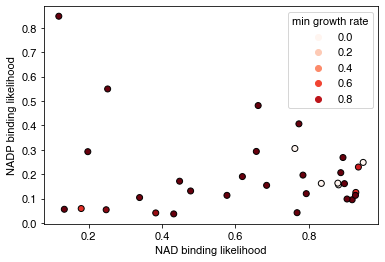

In [497]:
a4_dims = (6, 4)
fig, ax = plt.subplots(figsize=a4_dims)
plt.rcParams.update({'font.size': 11})
sns.scatterplot(x='nad',y='nadp',hue='min growth rate',data=mgr_cofac,palette='Reds',edgecolor='k',
                linewidth=1)
plt.xlabel('NAD binding likelihood')
plt.ylabel('NADP binding likelihood')
plt.savefig('nad_vs_nadp_minGrowthRate.svg')

<AxesSubplot:xlabel='log(NAD/NADP)', ylabel='min growth rate'>

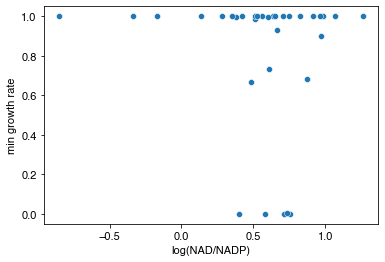

In [490]:
sns.scatterplot(x='log(NAD/NADP)',y='min growth rate',data=mgr_cofac)

In [422]:
mgr_cofac

,mean growth rate,KO,rossman_fold,from,to,fad,nad,nadp,coenzyme,rxns,wt_coenzyme,log(NAD/NADP)
b0116,1.239500,K00382,VPERLLVMGGGIIGLEMGTVYHALGSQIDVVEMFDQVIPAADKD,174.0,217.0,0.470,0.448,0.171,-,AKGDH;GLYCL;PDH,NAD,0.418282
b0356,1.000021,K00121,PGDSVAVFGLGAIGLAVVQGARQAKAGRIIAIDTNPKKFDLAR,186.0,228.0,0.177,0.935,0.229,NAD,ALCD19;FALDH2,NAD,0.610976
b0596,1.000000,K00216,SGKNVWVTGAGKGIGYATALAFVEAGAKVTGFDQAFTQEQ,4.0,43.0,0.043,0.918,0.095,NAD,DHBD,NAD,0.985119
b1385,1.000020,K00146,HVAKISFTGSTATGKGIARTAADHLTRVTLELGGKNP,242.0,278.0,0.023,0.887,0.206,NAD,ALDD19xr,NAD,0.634056
b1395,0.998391,K00074,NVQTVAVIGSGTMGAGIAEVAASHGHQVLLYDISAEALTRAIDGI,4.0,48.0,0.277,0.881,0.156,NAD,HADPCOADH3,NAD,0.751851
b1479,1.038809,K00027,SEKKIVFLGAGSAGCGIAEMIISQTQREGLSEEAARQKVFMVDRFGLL,294.0,341.0,0.286,0.432,0.037,-,ME1,NAD,1.067282
b1525,1.000000,K08324,AAVTVTGSVRAGAAIGAQAGAALKKCVLELGGSDP,206.0,240.0,0.066,0.768,0.042,NAD,SSALx,NAD,1.262112
b1692,1.000000,K05887,KGKTMVLLGAGGASTAIGAQGAIEGLKEIKLFNRRDEFFD,123.0,162.0,0.038,0.662,0.481,NAD,QUINDH,NAD,0.138713
b1746,1.000082,K06447,GLLFTGSANTGYQLHRQLSGQPEKILALEMGGNN,215.0,248.0,0.087,0.478,0.131,-,SGSAD,NAD,0.562157
b1779,0.721295,K00134,MTIKVGINGFGRIGRIVFRAAQKRSDIEIVAINDLLDADYMAYMLK,1.0,46.0,0.001,0.948,0.248,NAD,GAPD,NAD,0.582357
